# Mini Project 4

By the deadline (**26.01.2026**), please submit the provided Jupyter notebook with all/some required tasks completed and clearly solved. Make sure your code is neat, well-commented, and that all outputs are visible (run all cells before saving). Notebooks with missing tasks or unexecuted cells may receive fewer points. After you submit, you won’t be able to make changes, so double-check your work and be sure to start from the provided template

## Submission rules
As already discussed in class, we will stick to the following rules.
- Use the templates and name your files `NAME_SURNAME.ipynb` (If you have more than one name, just concatenate them). We will compare what you present with that file. 
- Code either not written in Python or not using PyTorch receives a grade of 0. Of course, you can use auxiliary packages when needed (`matplotlib`, `numpy`, `networkx`...), but for the learning part, you must use PyTorch.
-  If plagiarism is suspected, TAs and I will thoroughly investigate the situation, and we will summon the student for a face-to-face clarification regarding certain answers they provided. In case of plagiarism, a score reduction will be applied to all the people involved, depending on their level of involvement.
-  If extensive usage of AI tools is detected, we will summon the student for a face-to-face clarification regarding certain answers they provided. If the answers are not adequately supported with in-person answers, we will proceed to apply a penalty to the evaluation, ranging from 10% to 100%.

## Traveling Salesperson Problem (TSP) – Heuristic with Transformers

### Introduction

The Traveling Salesperson Problem (TSP) is a classical combinatorial optimization problem: given a set of cities and the distances between them, the goal is to find the shortest possible tour that visits each city exactly once and returns to the starting point. See this picture for reference. 

![TSP](https://optimization.cbe.cornell.edu/images/e/ea/48StatesTSP.png)

TSP is NP-hard, meaning that finding the optimal solution becomes computationally intractable as the number of cities grows. Therefore, in practice, we often rely on heuristic or approximate algorithms to find good solutions in a reasonable time.

In this assignment, your task is to implement a heuristic TSP solver for Euclidean TSP using a Transformer-based model. 

Euclidean TSP is a TSP where all the cities are assumed to be in the Euclidean 2D space and the distance is computed acording to the standard Euclidean norm.

The Transformer architecture, widely used in natural language processing, can also model sequences of nodes in a graph. By training a Transformer on TSP instances, you can generate tours in an autoregressive manner selecting one city at a time based on previously chosen cities.

This assignment will help you to understand how sequence models like Transformers can be applied beyond text, to combinatorial problems and practice autoregressive generation and masking techniques for sequence prediction.

Most of the code is provided. This **does not mean that you are allowed to use it blindly**: make sure to understand what is happening.

In [14]:
import networkx as nx
import torch
import torch.nn as nn
import math
from networkx.algorithms.approximation import greedy_tsp
import numpy as np
import pickle
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader

torch.manual_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Task 1 (0 pts)

Learn how to use the [NetworkX](https://networkx.org/documentation/stable/tutorial.html) package. The section on Graphs should be sufficient for this assignment. You can skip the sections on directed graphs and beyond.


### Utility Functions

Below are some utility functions. Detailed explanations are provided in each function’s description. At a high level, these functions do the following:

* `random_tour`: Takes a `networkx.Graph` as input and returns a random tour. This can serve as a simple heuristic, but its performance is generally low, as expected.
* `tour_length`: Takes a `networkx.Graph` and a tour (encoded as a `list` that starts and ends at the same node) and returns the total length of the tour.
* `gap`: Measures the quality of a tour by computing

$$ \dfrac{\text{Estimated} - \text{Optimal}}{\text{Optimal}} $$

As you might expect, lower values are better, with a gap of zero indicating that the tour is exactly optimal.


In [15]:
def random_tour(G: nx.Graph) -> float:
    """
    Generate a random TSP tour for a given graph.

    Parameters
    ----------
    G : networkx.Graph
        A graph representing the TSP instance. Nodes should be numbered from 0 to n-1.

    Returns
    -------
    tour : list of int
        A list of node indices representing a complete tour starting and ending at node 0.
        Each node appears exactly once in the tour (except the start/end node).
    """
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour

def tour_length(G: nx.Graph, tour: list[int]) -> float:
    """
    Compute the total length of a TSP tour.

    Parameters
    ----------
    G : nx.Graph
        A graph representing the TSP instance with edge weights.
    tour : list of int
        A tour represented as a list of node indices starting and ending at the same node.
        Each node appears exactly once in the tour (except the start/end node).

    Returns
    -------
    length : float
        The total length (cost) of the tour.
    """
    length = 0.0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i + 1]
        length += G[u][v]['weight']
    return length

def gap(estimated : float, optimal : float) -> float:
    """
    Compute the relative optimality gap of a TSP tour.

    Parameters
    ----------
    estimated : float
        The total cost of the computed tour.
    optimal : float
        The cost of the known optimal tour.

    Returns
    -------
    gap : float
        The relative gap between the estimated and optimal cost,
        computed as (estimated - optimal) / optimal.
    """
    return (estimated - optimal) / optimal

### Task 2 (10 pts)

The dataset has already been prepared for your convenience and is split into training, validation, and test sets. Load it using [pickle](https://docs.python.org/3/library/pickle.html).

For this task, focus on the case **$n = 20$**, i.e., solving a TSP with 20 cities. Inspect each item in the dataset: what type is it? You should see that it is a `tuple` consisting of a `networkx` graph and a list representing the optimal tour (our ground truth).

Answer the following questions carefully:

* What does the node attribute `pos` represent?
* What does the edge attribute `weight` represent?
* What does the boolean edge attribute `tour` represent?

Do not proceed until you fully understand each of these components.


In [16]:
with open('/kaggle/input/dataset/train_20_DLL_ass4.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('/kaggle/input/dataset/valid_20_DLL_ass4.pkl', 'rb') as f:
    val_data = pickle.load(f)

with open('/kaggle/input/dataset/test_20_DLL_ass4.pkl', 'rb') as f:
    test_data = pickle.load(f)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

G, opt_tour = train_data[7]
print(f"\nFirst training instance:")
print(f"Graph type: {type(G)}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Optimal tour: {opt_tour}")
print(f"Tour length: {len(opt_tour)}")

print(f"\nNode 0 'pos' attribute: { [pos[1] for pos in list(G.nodes(data='pos'))] }")
print(f"\nEdge 'weight' and 'tour' attributes: {G.edges[0,1]}")

edges = list(G.edges())
print(len([edge for edge in edges if edge[0] == 0]))

Training set size: 50000
Validation set size: 1000
Test set size: 1000

First training instance:
Graph type: <class 'networkx.classes.graph.Graph'>
Number of nodes: 20
Optimal tour: [0, 2, 14, 1, 6, 12, 11, 19, 5, 3, 17, 13, 8, 18, 16, 7, 9, 15, 4, 10, 0]
Tour length: 21

Node 0 'pos' attribute: [(0.46203378210465795, 0.4770511500457346), (0.28364462189821793, 0.5360672375024884), (0.4540192555865865, 0.4546971569698208), (0.46615021065589257, 0.26809873223841485), (0.5095450261334403, 0.6962889237122366), (0.3067685672512598, 0.17397204157214574), (0.2700512642728443, 0.6677624191085975), (0.6514706306948652, 0.8277557268891667), (0.8990143962593952, 0.3466393146638205), (0.6263171831171077, 0.8976151611441038), (0.6292084045044446, 0.4907824624998379), (0.13762811540636855, 0.6183375518573782), (0.15617939562186534, 0.7283625470427517), (0.6767025172132546, 0.2610488076693781), (0.4322594372235402, 0.5013438654640012), (0.5717790526341701, 0.7505995755719715), (0.697923109480254, 0.6

### Taks 3 (4 pts)

In this task, you will implement a custom PyTorch Dataset to handle TSP instances. Your dataset should take as input a list of tuples, where each tuple contains:

1. A `networkx` graph representing the cities and their distances.
2. A list representing the optimal tour (ground truth).

You should implement a class `TSPDataset` that returns, for a given index `idx`, a tuple `(X, opt_tour)` where:

  * `X` is a tensor of shape `[n_nodes, 2]` containing the coordinates of each node (from the node attribute `pos`).
  * `opt_tour` is a tensor containing the optimal tour as a sequence of node indices.

Then, create a dataset object for both training, validation and test sets.

In [17]:
class TSPDataset(torch.utils.data.Dataset):
    def __init__(self, data ):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (G, opt_tour) = self.data[idx]
        #positions = [pos[1] for pos in list(G.nodes(data='pos'))]

        pos_dict = nx.get_node_attributes(G, 'pos')
        coords = []
        for i in range(G.number_of_nodes()):
            coords.append(pos_dict[i])
        
        
        X = torch.tensor(coords, dtype=torch.float32)
        opt_tour = torch.tensor(opt_tour)
        
        return (X, opt_tour)

### Task 4 (3 pts)

Create the `Dataloader` objects for training and validation. Probably you just need training and validation loader.

In [18]:
batch_size = 64

train_dataloader = DataLoader(dataset=TSPDataset(train_data), batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(dataset=TSPDataset(val_data), batch_size=batch_size)

for data, target in train_dataloader:
    print(data.shape)
    print(target.shape)
    break


torch.Size([64, 20, 2])
torch.Size([64, 21])


### Task 5 (5 pts)

Implement Positional encoding for sequence models. Positional encoding allows a Transformer to incorporate information about the order of elements in a sequence, since the model itself is permutation-invariant.

You are asked to implement a function/a class that takes as input:

  * `seq_len`: the length of the sequence (number of positions).
  * `embed_dim`: the dimensionality of the embedding vectors.

And returns a tensor of shape `[seq_len, embed_dim]`, where each row corresponds to the positional encoding vector for a position in the sequence.

In [19]:
# Option 1: Function-based implementation
def positional_encoding(seq_len, embed_dim):
    pass

# Option 2: Module-based implementation
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, embed_dim):
        super().__init__()
        
        position = torch.arange(max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * 
                             (-math.log(10000.0) / embed_dim))
        
        pe = torch.zeros(max_seq_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)

### Task 6 (30 pts)

In this task, you are asked to implement a Transformer-like architecture. You have two options:

1. Implement the architecture provided in the pdf and sketched with guidance in the next cell. This option is fully guided, however, following it exactly will give you full points.

2. Implement your own Transformer-based architecture. You are free to design it as you wish, as long as it is Transformer-based. No extra points will be awarded for choosing this option, but full points can still be earned if it works correctly.

Choose the approach that best suits your preference and experience.

In [ ]:
class TSPTransformer(nn.Module):
    def __init__(self,
        n: int,
        d_model: int,
        nhead_encoder: int,
        nhead_decoder: int,
        n_encoder_layers: int,
        n_decoder_layers: int,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.d_model = d_model
        self.dropout = dropout
        self.n = n

        dim_feedforward = 4 * d_model
        ######################################
        # Feature expansion
        #####################################
        
        # Linear layer
        self.feature_exp = nn.Linear(2,d_model)

        # Encoder Embedding: n x d (for node indices 0 to n-1)
        self.input_embedding = nn.Embedding(n, d_model)

        ######################################
        # Encoder
        #####################################
        # Encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead_encoder, 
            dim_feedforward=dim_feedforward,
            dropout=dropout, 
            batch_first=True,
            activation='gelu'
        )

        # Encoder
        self.encoder = nn.TransformerEncoder(encoder_layer, n_encoder_layers)
        
        ######################################
        # Encoder Output linear layer: d x d
        #####################################
        self.encoder_linear = nn.Linear(d_model, d_model)

        ######################################
        # Decoder
        #####################################
        
        # Decoder Embedding: n x d (SAME as the encoder)
        
        # Learned Positional Encoding Embedding: n x d (for positions in the tour)
        self.pos_embedding =  PositionalEncoding(n,d_model)     #nn.Embedding(n + 1, d_model)

        # Decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, 
            nhead=nhead_decoder, 
            dim_feedforward=dim_feedforward,
            dropout=dropout, 
            batch_first=True,
            activation='gelu'
        )

        # Decoder
        self.decoder = nn.TransformerDecoder(decoder_layer, n_decoder_layers)        
        
        ######################################
        # Decoder Output linear layer: d x n
        #####################################
        self.decoder_linear = nn.Linear(d_model, n)
        
        #self.apply(self.init_weights)

    def forward(self, X, src):
        batch_size = X.size(0) 
        seq_len = src.size(1)  #  src: tour so far [batch, seq_len]
        
        # Encoder: Linear(coordinates) + Embedding(node_indices)
        encoder_FE = self.feature_exp(X)   # [batch, n, d_model]
        
        node_indices = torch.arange(self.n, device=X.device).unsqueeze(0).expand(batch_size, -1)
        encoder_emb = self.input_embedding(node_indices) # [batch, n, d_model]
        
        encoder_input = (encoder_FE + encoder_emb)
        
        encoder_out = self.encoder(encoder_input)
        memory = self.encoder_linear(encoder_out)  # [batch, n, d_model] - this is "Memory"

        # Decoder: Embedding(tour_indices) + Positional_Embedding
        decoder_emb = self.input_embedding(src) # [batch, seq_len, d_model]
        
        decoder_input = self.pos_embedding(decoder_emb)

        # Create causal mask for autoregressive decoding
        mask = self.create_mask(seq_len, X.device)

        decoder_out = self.decoder(tgt=decoder_input, memory=memory, tgt_mask=mask)

        return self.decoder_linear(decoder_out)

    def create_mask(self, seq_len, device):
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=device)
        #mask = torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=device), diagonal=1)
        return mask
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0, std=0.02)  

### Task 7 (35 pts)

Train your model. Plot training and validation loss, clearly showing no overfitting.

In [ ]:
# Hyperparameters
n = 20  # Number of cities
d_model = 128
nhead_encoder = 8
nhead_decoder = 8
n_encoder_layers = 4
n_decoder_layers = 4
dropout = 0.1
learning_rate = 1e-3
num_epochs = 50

# Initialize model
model = TSPTransformer(
    n=n,
    d_model=d_model,
    nhead_encoder=nhead_encoder,
    nhead_decoder=nhead_decoder,
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    dropout=dropout
).to(DEVICE)

def lr(epochs):
    warmup_epochs = 5
    if epochs < warmup_epochs:
        return (epochs + 1) / warmup_epochs
    else:
        progress = (epochs - warmup_epochs) / (num_epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))
        
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"Training on device: {DEVICE}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch, tour_batch in train_dataloader:
        X_batch = X_batch.to(DEVICE)
        tour_batch = tour_batch.to(DEVICE)
        
        # Input: tour[:-1] (all except last city)
        # Target: tour[1:] (all except first city)
        src = tour_batch[:, :-1]  # [batch, seq_len]
        target = tour_batch[:, 1:]  # [batch, seq_len]
        
        optimizer.zero_grad()
        
        logits = model(X_batch, src)  # [batch, seq_len, n]
        
        logits = logits.reshape(-1, n)  # [batch*seq_len, n]
        target = target.reshape(-1)  # [batch*seq_len]
        
        loss = criterion(logits, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, tour_batch in val_dataloader:
            X_batch = X_batch.to(DEVICE)
            tour_batch = tour_batch.to(DEVICE)
            
            src = tour_batch[:, :-1]
            target = tour_batch[:, 1:]
            
            logits = model(X_batch, src)
            
            logits = logits.reshape(-1, n)
            target = target.reshape(-1)
            
            loss = criterion(logits, target)
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    #scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

model.load_state_dict(best_model_state)


Training on device: cuda
Model parameters: 1,873,428
Epoch [1/50] - Train Loss: 2.1641, Val Loss: 2.0154
Epoch [5/50] - Train Loss: 2.0049, Val Loss: 1.9906
Epoch [10/50] - Train Loss: 1.9900, Val Loss: 1.9810
Epoch [15/50] - Train Loss: 1.1059, Val Loss: 0.6268
Epoch [20/50] - Train Loss: 0.4942, Val Loss: 0.3583
Epoch [25/50] - Train Loss: 0.4133, Val Loss: 0.3185
Epoch [30/50] - Train Loss: 0.3705, Val Loss: 0.2980
Epoch [35/50] - Train Loss: 0.3415, Val Loss: 0.2823
Epoch [40/50] - Train Loss: 0.3196, Val Loss: 0.2757
Epoch [45/50] - Train Loss: 0.3016, Val Loss: 0.2679
Epoch [50/50] - Train Loss: 0.2859, Val Loss: 0.2670
Training completed!


<All keys matched successfully>

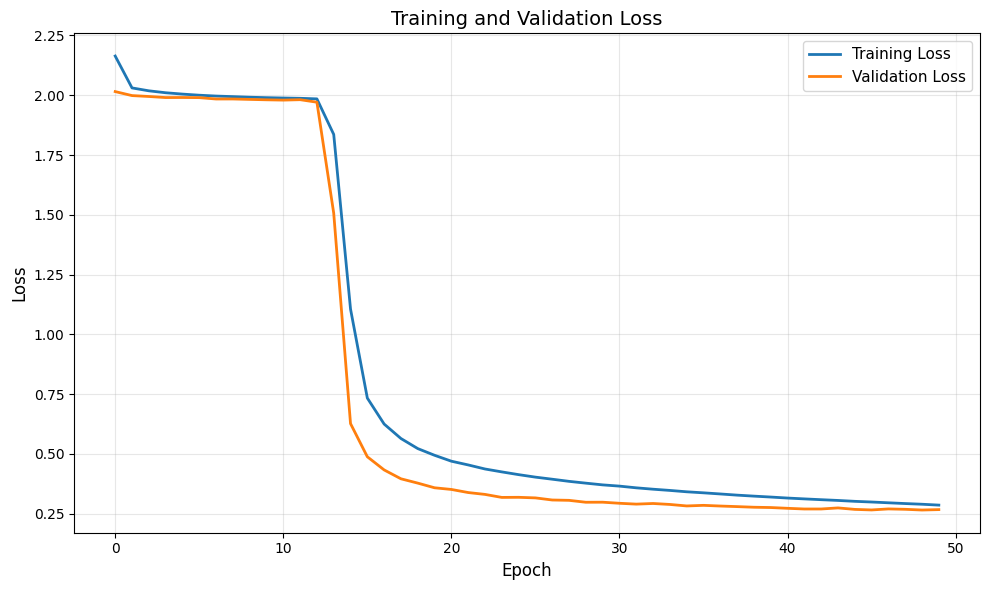


Final Training Loss: 0.2859
Final Validation Loss: 0.2670


In [22]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

### Task 8 (3 pts)

Finally, evaluate your model as if it were a heuristic for solving the TSP. Compare its performance with other simple baselines, such as:

* A random tour sampled uniformly at random
* The greedy heuristic, where you start from a given city and repeatedly move to the closest unvisited one. Its theoretical performance guarantees are quite weak, but in practice it can sometimes work surprisingly well.

The code needed to run these baselines is already provided in the next cells. There is just something you may want to check in the second cell after this one.
Before using it, make sure you fully understand what each part of the provided code is doing.

At the very end, you should see something like this, with our trained model beating all the baselines:

```
Greedy TSP average gap: 0.171123
Random TSP average gap: 1.745515
Our TSP average gap: 0.05374
```



In [23]:
def transformer_tsp(G, model, start_node = 0, DEVICE="cpu"):
    """
    Evaluate a trained Transformer-based TSP heuristic on a given graph G.

    This function performs greedy autoregressive decoding: starting from node 0,
    it repeatedly queries the model to predict the next city to visit, always
    selecting the highest-scoring unvisited node. The predicted tour is finally
    closed by returning to the starting point.

    Parameters
    -----------
        G (networkx.Graph):
            A TSP instance where each node has a 'pos' attribute containing its
            2D coordinates.
        model (torch.nn.Module):
            A trained Transformer-like neural network that takes:
                - x: a tensor of node coordinates  
                - y: the partial tour so far       
              and outputs logits for the next node at each decoding step.
        start_node (int):
            The starting node; default is zero.
        DEVICE (str, optional):
            Device to run the model on (“cpu” or “cuda” (<-- GPU)). Default is "cpu".

    Returns:
    --------
        float:
            The length of the predicted tour, computed using `tour_length`.
    """

    # Set the model in evaluation mode (important for layers like dropout)
    model.eval()

    # Number of nodes
    n = G.number_of_nodes()

    # Extract node coordinates into a tensor of shape [n, 2]
    attr = nx.get_node_attributes(G, "pos")
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))
    x = torch.stack(x)

    # Initial tour starts at node 0
    tour = [start_node]
    y = torch.tensor(tour, dtype=torch.long)

    # Move tensors to the desired device and add batch dimension
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)

    # First forward pass
    out = model(x, y)

    # Autoregressive greedy decoding
    while len(tour) < n:
        # Get nodes sorted by descending score
        _, idx = torch.topk(out, n, dim=2)

        # Pick the highest-scoring unvisited node
        for i in range(n):
            if idx[0, -1, i] not in tour:
                tour.append(idx[0, -1, i])
                break

        # Update decoder input and run model again
        y = torch.tensor(tour, dtype=torch.long).to(DEVICE).unsqueeze(0)
        out = model(x, y)

    # Close the tour by returning to the starting node
    tour = [int(i) for i in tour] + [start_node]

    # Compute and return its length
    return tour_length(G, tour)

In [24]:
"""
TODO
1. Load / Use the model you want to use (I guess, your best/last model)
2. Have you loaded the training data?
"""

'\nTODO\n1. Load / Use the model you want to use (I guess, your best/last model)\n2. Have you loaded the training data?\n'

In [25]:
model = model
X_test = test_data

optimal_tours_values = []
greedy_tsp_values = []
random_tsp_values = []
our_heuristic_values = []

for idx, (G, y_opt) in tqdm(enumerate(X_test), total=len(X_test)):
    # OPT
    optimal_tours_values.append(tour_length(G, y_opt))

    # Greedy TSP
    tour_greedy = greedy_tsp(G)
    greedy_tsp_values.append(tour_length(G, tour_greedy))

    # Random TSP
    tour_random = random_tour(G)
    random_tsp_values.append(tour_length(G, tour_random))

    # Our Heuristic
    our_heuristic_values.append(transformer_tsp(G, model, DEVICE=DEVICE))

100%|██████████| 1000/1000 [02:49<00:00,  5.91it/s]


In [26]:
# Greedy TSP gap
gaps_greedy = []
for i in range(len(X_test)):
    gap_greedy = gap(greedy_tsp_values[i], optimal_tours_values[i])
    gaps_greedy.append(gap_greedy)
print("Greedy TSP average gap:", np.mean(gaps_greedy), flush=True)

# Random TSP gap
gaps_random = []
for i in range(len(X_test)):
    gap_random = gap(random_tsp_values[i], optimal_tours_values[i])
    gaps_random.append(gap_random)
print("Random TSP average gap:", np.mean(gaps_random), flush=True)

# Our Heuristic
gaps_our = []
for i in range(len(X_test)):
    gap_our = gap(our_heuristic_values[i], optimal_tours_values[i])
    gaps_our.append(gap_our)
print("Our TSP average gap:", np.mean(gaps_our), flush=True)

Greedy TSP average gap: 0.1711230744772561
Random TSP average gap: 1.7328450816571632
Our TSP average gap: 0.031686190592075475


## Questions

1. Can you use this model for a TSP instance with 50 nodes? How can you improve it?
2. What is attention and why is it the core mechanism of Transformers?
3. How does multi-head attention differ from single-head attention? Why is it useful?
4. What is the purpose of positional encodings in a Transformer? Why are they needed?
5. Describe the role of the feed-forward network inside each Transformer layer.
6. Why do Transformers use Layer Normalization instead of Batch Normalization?
7.  What are Q, K, and V? Explain their dimensions intuitively.
8. Why do we scale the dot product by √dₖ in scaled dot-product attention?
9. What is the intuition behind causal masking?
11. What is the difference between training-time input and inference-time input in autoregressive models? What is teacher forcing? Why is it used?
12. What is tokenization and why does it matter for LLM performance?
13. What is the difference between pretraining and finetuning?
14. Explain greedy decoding vs. sampling vs. beam search.